In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ma4 = np.array([1, 0, 0,0,0])
ar4 = np.array([1, -0.26, -0.23,-0.15,-0.20])

AR4_process = ArmaProcess(ar4, ma4).generate_sample(nsample=1000)
df=pd.DataFrame(AR4_process)
df.rename(columns={0:'AR4_process'},inplace=True)
df

,AR4_process
0,0.496714
1,-0.009119
2,0.759562
3,1.792926
4,0.504682
...,...
995,-1.741466
996,0.458576
997,-0.244426
998,-1.183488


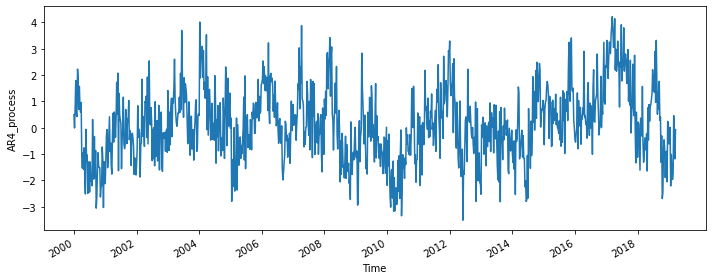

In [3]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(df['AR4_process'])
ax.set_xlabel('Time')
ax.set_ylabel('AR4_process')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [4]:
ADF_result = adfuller(df['AR4_process'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.672089841484539
p-value: 8.874290952633627e-07


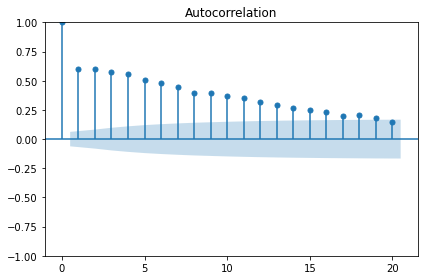

In [5]:
plot_acf(df['AR4_process'], lags=20);

plt.tight_layout()

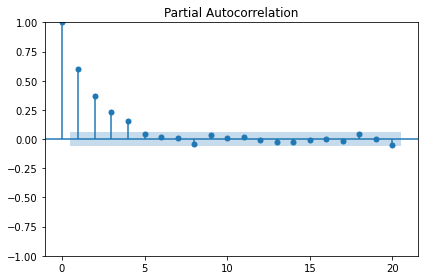

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df['AR4_process'], lags=20);

plt.tight_layout()

In [7]:
train = df[:-52]
test = df[-52:]

print(len(train))
print(len(test))

948
52


In [8]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(4,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [9]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

pred_mean = pred_mean[:HORIZON]
pred_last_value = pred_last_value[:HORIZON]
pred_AR = pred_AR[:HORIZON]

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,AR4_process,pred_mean,pred_last_value,pred_AR
948,-0.386534,0.134403,-1.001747,-0.439345
949,-0.407445,0.134403,-1.001747,-0.690015
950,-0.848600,0.134403,-1.001747,-0.674246
951,-0.220622,0.134403,-1.001747,-0.575962
952,-1.642503,0.131881,-0.220622,-0.392768


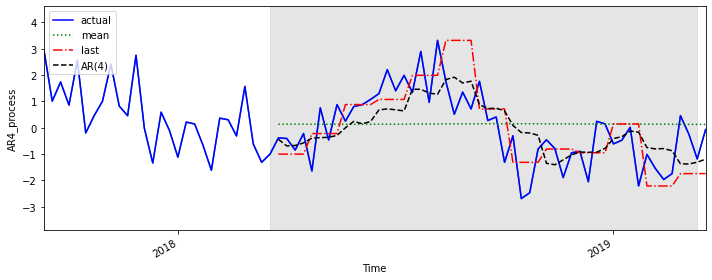

In [10]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(df['AR4_process'])
ax.plot(df['AR4_process'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(4)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('AR4_process')

ax.axvspan(947, 998, color='#808080', alpha=0.2)

ax.set_xlim(920, 999)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

In [11]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['AR4_process'], test['pred_mean'])
mse_last = mean_squared_error(test['AR4_process'], test['pred_last_value'])
mse_AR = mean_squared_error(test['AR4_process'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

1.8635805107883097 1.2956783412950599 1.0661756251752945


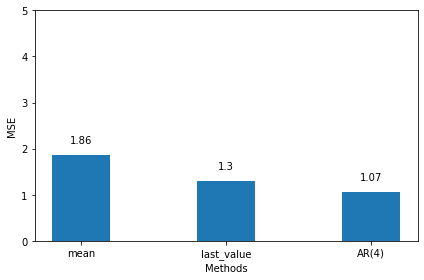

In [12]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(4)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [13]:
df['pred_AR4_process'] = pd.Series()
df['pred_AR4_process'][948:] = df['AR4_process'].iloc[948] + test['pred_AR'].cumsum()

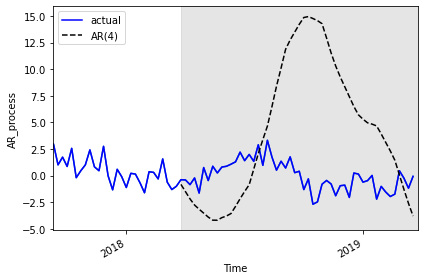

In [14]:
fig, ax = plt.subplots()

ax.plot(df['AR4_process'])
ax.plot(df['AR4_process'], 'b-', label='actual')
ax.plot(df['pred_AR4_process'], 'k--', label='AR(4)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('AR_process')

ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()


In [15]:
from sklearn.metrics import mean_absolute_error

mae_AR_undiff = mean_absolute_error(df['AR4_process'][948:], df['pred_AR4_process'][948:])

print(mae_AR_undiff)

6.4375363367457785
